# Neural Networks for Classification - Predicting Chronic Disease Status

This notebook will teach you how to use **neural networks** (also called deep learning) to predict whether someone has a chronic disease based on their health and lifestyle data.

**What we'll learn:**
1. How neural networks work for classification problems
2. Prepare health data specifically for neural networks
3. Build a neural network from scratch using PyTorch
4. Train the network and watch it learn
5. Compare performance with traditional ML models
6. Advanced techniques: regularization and cross-validation

**Why neural networks for health prediction?**
- Can learn complex, non-linear patterns in health data
- Automatically discover interactions between lifestyle factors
- Often more accurate with large datasets
- Foundation of modern AI in healthcare

**What you need:**
- Clean health data from previous notebooks
- Basic understanding of machine learning concepts
- Curiosity about how AI can help in healthcare!

**Instructions:**
- Run each cell one by one
- Read the explanations carefully
- Experiment with the parameters!

In [18]:
# Import libraries for neural networks and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Traditional ML for comparison
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# PyTorch for neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Set random seeds for reproducible results
np.random.seed(42)
torch.manual_seed(42)

print("🧠 Libraries imported successfully!")
print("🎯 Ready to build neural networks!")
print("🔥 PyTorch version:", torch.__version__)

🧠 Libraries imported successfully!
🎯 Ready to build neural networks!
🔥 PyTorch version: 2.4.1


## 1. Load and Explore Our Health Dataset

First, let's load our cleaned health dataset and understand what we're working with.

In [19]:
# Load the cleaned health dataset
df = pd.read_csv('../datasets/health_cleaned_data.csv')

print(f"🏥 Health dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"This means we have {df.shape[0]} patient records with {df.shape[1]} different health features")

# Look at the first few rows
print("\n👀 First 5 rows of our dataset:")
display(df.head())

🏥 Health dataset loaded successfully!
Shape: 7163 rows × 13 columns
This means we have 7163 patient records with 13 different health features

👀 First 5 rows of our dataset:


,ID,Age,Gender,Height_cm,Weight_kg,BMI,Smoker,Exercise_Freq,Diet_Quality,Alcohol_Consumption,Chronic_Disease,Stress_Level,Sleep_Hours
0,2,69,Other,169.3,70.7,24.7,No,1-2 times/week,Good,High,No,2,5.9
1,3,46,Female,159.1,69.0,27.3,No,Daily,Excellent,Moderate,No,3,4.8
2,4,32,Male,170.6,76.4,26.3,No,3-5 times/week,Excellent,Moderate,No,9,6.6
3,5,60,Male,158.4,60.4,24.1,No,3-5 times/week,Excellent,Low,Yes,6,6.1
4,6,25,Female,167.7,62.0,22.0,No,Daily,Good,Moderate,No,1,5.8


In [20]:
# Explore the dataset structure
print("🏥 HEALTH DATASET OVERVIEW")
print("=" * 50)

print(f"🎯 Our goal: Predict 'Chronic_Disease' status (Yes/No) using health and lifestyle features")

# Check the target variable distribution
chronic_disease_counts = df['Chronic_Disease'].value_counts()
print(f"\n📊 Chronic Disease Distribution:")
for status, count in chronic_disease_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {status}: {count} patients ({percentage:.1f}%)")

print(f"\n📝 Available health features:")
for i, col in enumerate(df.columns, 1):
    dtype = df[col].dtype
    unique_vals = df[col].nunique()
    print(f"  {i:2d}. {col:<20} - {dtype} ({unique_vals} unique values)")

# Show some basic health statistics
print(f"\n🔍 Health Statistics:")
print(f"Age range: {df['Age'].min():.0f} to {df['Age'].max():.0f} years")
print(f"Average BMI: {df['BMI'].mean():.1f}")
print(f"Average sleep: {df['Sleep_Hours'].mean():.1f} hours")

print(f"\n📈 Lifestyle factors:")
print("Exercise frequency:")
print(df['Exercise_Freq'].value_counts().head())

🏥 HEALTH DATASET OVERVIEW
🎯 Our goal: Predict 'Chronic_Disease' status (Yes/No) using health and lifestyle features

📊 Chronic Disease Distribution:
  No: 5772 patients (80.6%)
  Yes: 1391 patients (19.4%)

📝 Available health features:
   1. ID                   - int64 (7163 unique values)
   2. Age                  - int64 (52 unique values)
   3. Gender               - object (3 unique values)
   4. Height_cm            - float64 (540 unique values)
   5. Weight_kg            - float64 (705 unique values)
   6. BMI                  - float64 (334 unique values)
   7. Smoker               - object (2 unique values)
   8. Exercise_Freq        - object (3 unique values)
   9. Diet_Quality         - object (4 unique values)
  10. Alcohol_Consumption  - object (3 unique values)
  11. Chronic_Disease      - object (2 unique values)
  12. Stress_Level         - int64 (10 unique values)
  13. Sleep_Hours          - float64 (80 unique values)

🔍 Health Statistics:
Age range: 18 to 69 years
A

## 2. Prepare Data for Neural Networks

Neural networks need data in a specific format. Let's prepare our features and target variable for classification.

**Key steps for classification:**
1. **Choose features** - What health information will help predict chronic disease?
2. **Encode categorical variables** - Convert text to numbers
3. **Scale numerical features** - Make all numbers similar ranges
4. **Encode target variable** - Convert Yes/No to 1/0
5. **Split data** - Separate training and testing sets

In [21]:
# STEP 1: Choose our target and features
print("🎯 CHOOSING TARGET AND FEATURES")
print("=" * 40)

# Target: what we want to predict (Yes/No chronic disease)
target = 'Chronic_Disease'
print(f"Target variable: {target}")

# Features: what we'll use to make predictions
# Let's choose the most important health and lifestyle features
features = [
    'Age',                    # Age of the person
    'Gender',                 # Male/Female/Other
    'BMI',                    # Body Mass Index
    'Smoker',                 # Yes/No smoking status
    'Exercise_Freq',          # Exercise frequency
    'Diet_Quality',           # Diet quality rating
    'Alcohol_Consumption',    # Alcohol consumption level
    'Stress_Level',           # Stress level (1-10)
    'Sleep_Hours'             # Hours of sleep per night
]

print(f"Selected health features: {features}")

# Create our working dataset
work_df = df[features + [target]].copy()
print(f"\nWorking dataset shape: {work_df.shape}")

# Check for missing values
missing_values = work_df.isnull().sum()
if missing_values.sum() > 0:
    print(f"⚠️  Missing values found:")
    print(missing_values[missing_values > 0])
else:
    print("✅ No missing values found!")

# Show target distribution
print(f"\n🏥 Target variable distribution:")
target_dist = work_df[target].value_counts()
for status, count in target_dist.items():
    percentage = (count / len(work_df)) * 100
    print(f"  {status}: {count} patients ({percentage:.1f}%)")

🎯 CHOOSING TARGET AND FEATURES
Target variable: Chronic_Disease
Selected health features: ['Age', 'Gender', 'BMI', 'Smoker', 'Exercise_Freq', 'Diet_Quality', 'Alcohol_Consumption', 'Stress_Level', 'Sleep_Hours']

Working dataset shape: (7163, 10)
✅ No missing values found!

🏥 Target variable distribution:
  No: 5772 patients (80.6%)
  Yes: 1391 patients (19.4%)


In [22]:
# STEP 2: Encode categorical variables and target
print("🔤 ENCODING CATEGORICAL VARIABLES")
print("=" * 40)

# Identify categorical and numerical features
categorical_features = work_df.select_dtypes(include=['object']).columns.tolist()
if target in categorical_features:
    categorical_features.remove(target)

numerical_features = work_df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# For neural networks, we'll use Label Encoding for categorical features
encoded_df = work_df.copy()
label_encoders = {}

for feature in categorical_features:
    print(f"\nEncoding {feature}:")
    print(f"  Original categories: {work_df[feature].nunique()}")
    
    le = LabelEncoder()
    encoded_df[feature] = le.fit_transform(work_df[feature].astype(str))
    label_encoders[feature] = le
    
    print(f"  Encoded to: 0 to {encoded_df[feature].max()}")
    
    # Show some examples
    original_sample = work_df[feature].unique()[:3]
    encoded_sample = [le.transform([cat])[0] for cat in original_sample]
    for orig, enc in zip(original_sample, encoded_sample):
        print(f"    '{orig}' → {enc}")

# STEP 3: Encode target variable (Yes/No → 1/0)
print(f"\n🎯 ENCODING TARGET VARIABLE:")
print(f"Converting '{target}' from Yes/No to 1/0")

target_encoder = LabelEncoder()
encoded_df[target] = target_encoder.fit_transform(work_df[target])

print(f"Encoding mapping:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"  '{class_name}' → {i}")

print(f"\n✅ All variables encoded!")
print(f"Final dataset shape: {encoded_df.shape}")

🔤 ENCODING CATEGORICAL VARIABLES
Categorical features: ['Gender', 'Smoker', 'Exercise_Freq', 'Diet_Quality', 'Alcohol_Consumption']
Numerical features: ['Age', 'BMI', 'Stress_Level', 'Sleep_Hours']

Encoding Gender:
  Original categories: 3
  Encoded to: 0 to 2
    'Other' → 2
    'Female' → 0
    'Male' → 1

Encoding Smoker:
  Original categories: 2
  Encoded to: 0 to 1
    'No' → 0
    'Yes' → 1

Encoding Exercise_Freq:
  Original categories: 3
  Encoded to: 0 to 2
    '1-2 times/week' → 0
    'Daily' → 2
    '3-5 times/week' → 1

Encoding Diet_Quality:
  Original categories: 4
  Encoded to: 0 to 3
    'Good' → 2
    'Excellent' → 1
    'Poor' → 3

Encoding Alcohol_Consumption:
  Original categories: 3
  Encoded to: 0 to 2
    'High' → 0
    'Moderate' → 2
    'Low' → 1

🎯 ENCODING TARGET VARIABLE:
Converting 'Chronic_Disease' from Yes/No to 1/0
Encoding mapping:
  'No' → 0
  'Yes' → 1

✅ All variables encoded!
Final dataset shape: (7163, 10)


In [23]:
# STEP 3: Prepare features and target
print("🎯 PREPARING FEATURES AND TARGET")
print("=" * 35)

# Separate features (X) and target (y)
X = encoded_df.drop(columns=[target])
y = encoded_df[target]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Show feature ranges before scaling
print(f"\nFeature ranges BEFORE scaling:")
print(X.describe().round(2))

# STEP 4: Scale the features
# Neural networks work best when all features are on similar scales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\nFeature ranges AFTER scaling:")
print(f"All features now have mean ≈ 0 and std ≈ 1")
print(f"Mean of all features: {X_scaled.mean().mean():.6f}")
print(f"Std of all features: {X_scaled.std().mean():.6f}")

print("\n✅ Features scaled and ready for neural network!")

🎯 PREPARING FEATURES AND TARGET
Features (X) shape: (7163, 9)
Target (y) shape: (7163,)

Feature ranges BEFORE scaling:
           Age   Gender      BMI   Smoker  Exercise_Freq  Diet_Quality  \
count  7163.00  7163.00  7163.00  7163.00        7163.00       7163.00   
mean     43.61     0.99    26.29     0.30           1.26          1.51   
std      14.92     0.81     6.19     0.46           0.83          1.12   
min      18.00     0.00    14.00     0.00           0.00          0.00   
25%      31.00     0.00    21.90     0.00           1.00          0.00   
50%      43.00     1.00    25.70     0.00           2.00          2.00   
75%      56.00     2.00    30.20     1.00           2.00          3.00   
max      69.00     2.00    56.80     1.00           2.00          3.00   

       Alcohol_Consumption  Stress_Level  Sleep_Hours  
count              7163.00       7163.00      7163.00  
mean                  0.99          5.58         7.10  
std                   0.70          2.87     

In [24]:
# STEP 5: Split data into training and testing sets
print("✂️  SPLITTING DATA")
print("=" * 20)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,      # For reproducible results
    stratify=y            # Ensure balanced split for classification
)

print(f"Training set: {X_train.shape[0]} patients")
print(f"Testing set: {X_test.shape[0]} patients")
print(f"Features: {X_train.shape[1]} health variables")

# Show target distribution in train/test sets
print(f"\n🏥 Target variable distribution:")
train_dist = y_train.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()

for class_label in [0, 1]:
    class_name = target_encoder.inverse_transform([class_label])[0]
    train_count = train_dist.get(class_label, 0)
    test_count = test_dist.get(class_label, 0)
    train_pct = (train_count / len(y_train)) * 100
    test_pct = (test_count / len(y_test)) * 100
    
    print(f"  {class_name}:")
    print(f"    Training: {train_count} ({train_pct:.1f}%)")
    print(f"    Testing:  {test_count} ({test_pct:.1f}%)")

print("\n✅ Data preparation complete!")
print("🧠 Ready to build our neural network for classification!")

✂️  SPLITTING DATA
Training set: 5730 patients
Testing set: 1433 patients
Features: 9 health variables

🏥 Target variable distribution:
  No:
    Training: 4617 (80.6%)
    Testing:  1155 (80.6%)
  Yes:
    Training: 1113 (19.4%)
    Testing:  278 (19.4%)

✅ Data preparation complete!
🧠 Ready to build our neural network for classification!


## 3. Understanding Neural Networks for Classification

Before we build our neural network, let's understand what we're creating for classification!

**What is a Classification Neural Network?**
- A network that predicts categories (Yes/No, healthy/diseased)
- Uses probability to make predictions (0-1 for binary classification)
- Similar structure to regression but with different output layer

**Our Neural Network Structure:**
```
Input Layer → Hidden Layer 1 → Hidden Layer 2 → Output Layer
   (9)     →      (64)      →      (32)      →     (1)
 health                                          probability
features                                       of chronic
                                               disease
```

**Key Differences from Regression:**
- **Output**: Probability (0-1) instead of continuous value
- **Activation**: Sigmoid function in output layer
- **Loss Function**: Binary Cross-Entropy instead of MSE
- **Metrics**: Accuracy, precision, recall instead of R²

In [25]:
# STEP 6: Convert to PyTorch tensors
print("🔥 CONVERTING TO PYTORCH TENSORS")
print("=" * 35)

print("What are tensors?")
print("- Tensors are like numpy arrays but optimized for neural networks")
print("- They can run on GPUs for faster computation")
print("- PyTorch uses them for all neural network operations")

# Convert our data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print(f"\n✅ Tensors created:")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

print(f"\nInput features: {X_train_tensor.shape[1]}")
print(f"Output predictions: {y_train_tensor.shape[1]} (disease probability)")

# Check if we can use GPU (faster training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
if device.type == "cuda":
    print("🚀 GPU available - training will be faster!")
else:
    print("💻 Using CPU - training will be slower but still works!")

🔥 CONVERTING TO PYTORCH TENSORS
What are tensors?
- Tensors are like numpy arrays but optimized for neural networks
- They can run on GPUs for faster computation
- PyTorch uses them for all neural network operations

✅ Tensors created:
X_train_tensor shape: torch.Size([5730, 9])
X_test_tensor shape: torch.Size([1433, 9])
y_train_tensor shape: torch.Size([5730, 1])
y_test_tensor shape: torch.Size([1433, 1])

Input features: 9
Output predictions: 1 (disease probability)

Using device: cpu
💻 Using CPU - training will be slower but still works!


## 4. Build Our Neural Network for Classification

Now let's create our classification neural network! We'll build it step by step so you understand each part.

**Our Network Architecture:**
1. **Input Layer**: 9 health features (age, BMI, lifestyle factors, etc.)
2. **Hidden Layer 1**: 64 neurons with ReLU activation
3. **Hidden Layer 2**: 32 neurons with ReLU activation  
4. **Output Layer**: 1 neuron with Sigmoid activation (outputs probability 0-1)

In [26]:
# Define our Classification Neural Network class
class ChronicDiseasePredictor(nn.Module):
    def __init__(self, input_size, hidden1_size=64, hidden2_size=32, dropout_rate=0.2):
        super(ChronicDiseasePredictor, self).__init__()
        
        print(f"🏗️  Building Classification Neural Network:")
        print(f"   Input Layer: {input_size} health features")
        print(f"   Hidden Layer 1: {hidden1_size} neurons")
        print(f"   Hidden Layer 2: {hidden2_size} neurons")
        print(f"   Output Layer: 1 neuron (chronic disease probability)")
        print(f"   Dropout Rate: {dropout_rate} (for regularization)")
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden1_size)      # First hidden layer
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)    # Second hidden layer
        self.fc3 = nn.Linear(hidden2_size, 1)               # Output layer
        
        # Regularization: Dropout prevents overfitting
        self.dropout = nn.Dropout(dropout_rate)
        
        # Activation functions
        self.relu = nn.ReLU()        # For hidden layers
        self.sigmoid = nn.Sigmoid()  # For output layer (gives probability 0-1)
        
    def forward(self, x):
        """
        Forward pass: how data flows through the network
        """
        # Input → Hidden Layer 1 → ReLU → Dropout
        x = self.dropout(self.relu(self.fc1(x)))
        
        # Hidden Layer 1 → Hidden Layer 2 → ReLU → Dropout  
        x = self.dropout(self.relu(self.fc2(x)))
        
        # Hidden Layer 2 → Output → Sigmoid (probability of chronic disease)
        x = self.sigmoid(self.fc3(x))
        
        return x

# Create our neural network
input_size = X_train_tensor.shape[1]  # Number of features
model = ChronicDiseasePredictor(input_size)

print(f"\n🧠 Classification Neural Network created!")
print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Show the network structure
print(f"\nNetwork Structure:")
print(model)

🏗️  Building Classification Neural Network:
   Input Layer: 9 health features
   Hidden Layer 1: 64 neurons
   Hidden Layer 2: 32 neurons
   Output Layer: 1 neuron (chronic disease probability)
   Dropout Rate: 0.2 (for regularization)

🧠 Classification Neural Network created!
📊 Total parameters: 2,753

Network Structure:
ChronicDiseasePredictor(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [27]:
# Setup training components for classification
print("⚙️  SETTING UP TRAINING COMPONENTS")
print("=" * 40)

# 1. Loss Function: Binary Cross-Entropy (for binary classification)
criterion = nn.BCELoss()
print("✅ Loss Function: Log-loss, also known as Binary Cross-Entropy (BCE)")
print("   - Measures how well probabilities match actual labels")
print("   - Penalizes confident wrong predictions more heavily")
print("   - Lower values = better predictions")

# 2. Optimizer: Adam (updates network weights to reduce loss)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
print(f"\n✅ Optimizer: Adam")
print(f"   - Learning Rate: {learning_rate} (how fast the network learns)")
print(f"   - Weight Decay: 1e-5 (L2 regularization to prevent overfitting)")

# 3. Data Loader: Processes data in batches for efficient training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"\n✅ Data Loader:")
print(f"   - Batch Size: {batch_size} (processes 32 patients at once)")
print(f"   - Shuffle: True (randomizes order each epoch)")
print(f"   - Total Batches: {len(train_loader)}")

print(f"\n🎯 Ready to train the classification neural network!")

⚙️  SETTING UP TRAINING COMPONENTS
✅ Loss Function: Log-loss, also known as Binary Cross-Entropy (BCE)
   - Measures how well probabilities match actual labels
   - Penalizes confident wrong predictions more heavily
   - Lower values = better predictions

✅ Optimizer: Adam
   - Learning Rate: 0.001 (how fast the network learns)
   - Weight Decay: 1e-5 (L2 regularization to prevent overfitting)

✅ Data Loader:
   - Batch Size: 32 (processes 32 patients at once)
   - Shuffle: True (randomizes order each epoch)
   - Total Batches: 180

🎯 Ready to train the classification neural network!


## 5. Train the Neural Network

Now comes the exciting part - watching our neural network learn to predict chronic disease! 

**Training Process for Classification:**
1. **Forward Pass**: Input health data flows through the network to make predictions
2. **Calculate Loss**: Compare predicted probabilities with actual disease status  
3. **Backward Pass**: Calculate how to adjust weights to reduce errors
4. **Update Weights**: Optimizer updates the network parameters
5. **Repeat**: Do this many times (epochs) until the network learns the patterns

**What to watch for:**
- **Training Loss**: Should decrease over time (network is learning)
- **Test Loss**: Should also decrease but may fluctuate
- **Accuracy**: Percentage of correct predictions (higher is better)
- **Best scenario**: Both losses decrease and accuracy increases

In [28]:
# Training function for classification
def train_epoch(model, train_loader, criterion, optimizer):
    """Train the model for one epoch"""
    model.train()  # Set model to training mode
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Forward pass: make predictions (probabilities)
        predictions = model(batch_X)
        
        # Calculate loss
        loss = criterion(predictions, batch_y)
        
        # Backward pass: calculate gradients
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate_model(model, X_test, y_test, criterion):
    """Evaluate model on test data for classification"""
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        # Get probabilities
        probabilities = model(X_test)
        test_loss = criterion(probabilities, y_test).item()
        
        # Convert probabilities to predictions (>0.5 = 1, <=0.5 = 0)
        predictions = (probabilities > 0.5).float()
        
        # Convert back to numpy for sklearn metrics
        y_test_np = y_test.numpy().flatten()
        predictions_np = predictions.numpy().flatten()
        probabilities_np = probabilities.numpy().flatten()
        
        # Calculate classification metrics
        accuracy = accuracy_score(y_test_np, predictions_np)
        auc_score = roc_auc_score(y_test_np, probabilities_np)
    
    return test_loss, accuracy, auc_score, predictions_np, probabilities_np

print("🚀 Starting training...")
print("=" * 30)

🚀 Starting training...


In [29]:
# Train the neural network for classification
epochs = 100
train_losses = []
test_losses = []
accuracies = []
auc_scores = []

print(f"Training for {epochs} epochs...")
print("Epoch | Train Loss | Test Loss | Accuracy | AUC Score")
print("-" * 55)

best_accuracy = 0
best_model_state = None

for epoch in range(epochs):
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    
    # Evaluate on test set
    test_loss, accuracy, auc_score, _, _ = evaluate_model(model, X_test_tensor, y_test_tensor, criterion)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    auc_scores.append(auc_score)
    
    # Save best model based on accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict().copy()
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"{epoch+1:5d} | {train_loss:10.4f} | {test_loss:9.4f} | {accuracy:8.3f} | {auc_score:9.3f}")

# Load best model
model.load_state_dict(best_model_state)

print(f"\n🎉 Training completed!")
print(f"🏆 Best Accuracy: {best_accuracy:.3f} ({best_accuracy*100:.1f}%)")

Training for 100 epochs...
Epoch | Train Loss | Test Loss | Accuracy | AUC Score
-------------------------------------------------------
   10 |     0.4945 |    0.4982 |    0.806 |     0.482
   10 |     0.4945 |    0.4982 |    0.806 |     0.482
   20 |     0.4919 |    0.5020 |    0.806 |     0.468
   20 |     0.4919 |    0.5020 |    0.806 |     0.468
   30 |     0.4895 |    0.5021 |    0.806 |     0.476
   30 |     0.4895 |    0.5021 |    0.806 |     0.476
   40 |     0.4795 |    0.5015 |    0.806 |     0.495
   40 |     0.4795 |    0.5015 |    0.806 |     0.495
   50 |     0.4777 |    0.5023 |    0.806 |     0.488
   50 |     0.4777 |    0.5023 |    0.806 |     0.488
   60 |     0.4765 |    0.5019 |    0.805 |     0.503
   60 |     0.4765 |    0.5019 |    0.805 |     0.503
   70 |     0.4709 |    0.5025 |    0.805 |     0.503
   70 |     0.4709 |    0.5025 |    0.805 |     0.503
   80 |     0.4704 |    0.5075 |    0.805 |     0.492
   80 |     0.4704 |    0.5075 |    0.805 |     0.492

## 6. Evaluate and Visualize Results

Let's see how well our neural network learned to predict chronic disease!

In [30]:
# Final evaluation for classification
print("🏥 FINAL NEURAL NETWORK PERFORMANCE")
print("=" * 50)

test_loss, accuracy, auc_score, predictions, probabilities = evaluate_model(model, X_test_tensor, y_test_tensor, criterion)

print(f"Test Loss (BCE): {test_loss:.4f}")
print(f"Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"AUC Score: {auc_score:.3f}")

# Generate detailed classification report
y_test_np = y_test_tensor.numpy().flatten()
print(f"\n📊 Detailed Classification Report:")
print(classification_report(y_test_np, predictions, 
                          target_names=['No Chronic Disease', 'Chronic Disease'],
                          digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test_np, predictions)
print(f"🔍 Confusion Matrix:")
print(f"                 Predicted")
print(f"                No    Yes")
print(f"Actual No    {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"Actual Yes   {cm[1,0]:4d}  {cm[1,1]:4d}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

print(f"\n💡 Clinical Interpretation:")
print(f"• Sensitivity (detecting disease): {sensitivity:.3f} ({sensitivity*100:.1f}%)")
print(f"• Specificity (correctly identifying healthy): {specificity:.3f} ({specificity*100:.1f}%)")
print(f"• Overall accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

if accuracy > 0.85:
    print("🏆 Excellent performance!")
elif accuracy > 0.75:
    print("✅ Good performance!")
elif accuracy > 0.65:
    print("⚠️  Okay performance - could be improved")
else:
    print("❌ Poor performance - needs significant improvement")

🏥 FINAL NEURAL NETWORK PERFORMANCE
Test Loss (BCE): 0.5068
Accuracy: 0.804 (80.4%)
AUC Score: 0.501

📊 Detailed Classification Report:
                    precision    recall  f1-score   support

No Chronic Disease      0.806     0.997     0.891      1155
   Chronic Disease      0.000     0.000     0.000       278

          accuracy                          0.804      1433
         macro avg      0.403     0.499     0.446      1433
      weighted avg      0.649     0.804     0.718      1433

🔍 Confusion Matrix:
                 Predicted
                No    Yes
Actual No    1152     3
Actual Yes    278     0

💡 Clinical Interpretation:
• Sensitivity (detecting disease): 0.000 (0.0%)
• Specificity (correctly identifying healthy): 0.997 (99.7%)
• Overall accuracy: 0.804 (80.4%)
✅ Good performance!


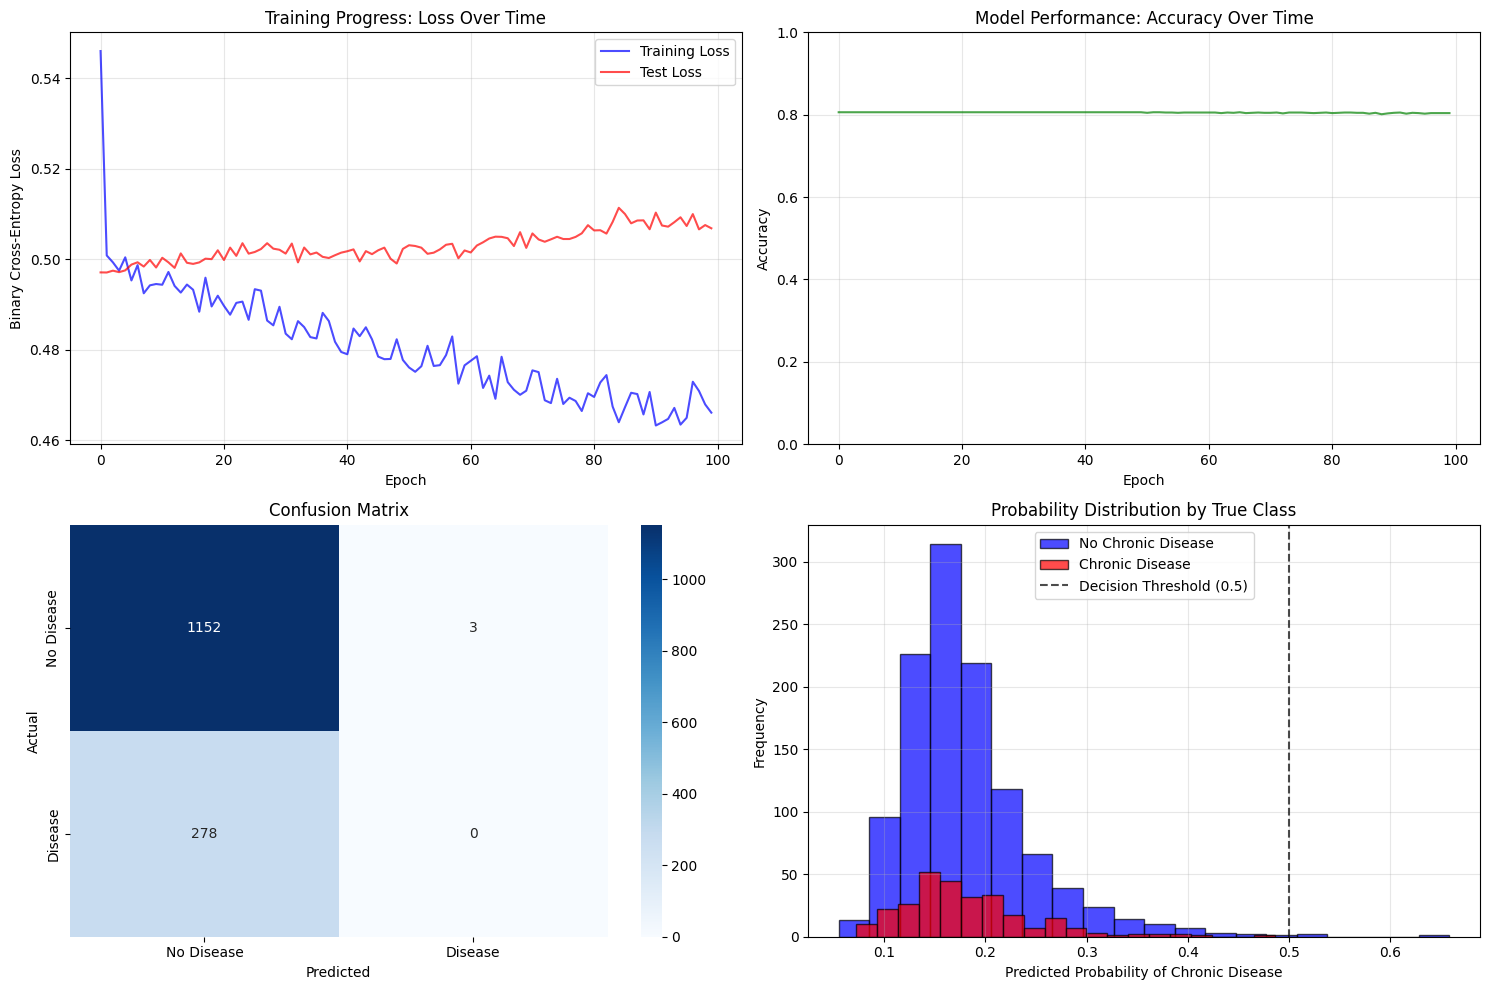

📈 Chart Interpretation:
• Top Left: Loss should decrease over time (network learning)
• Top Right: Accuracy should increase and stabilize
• Bottom Left: Confusion matrix shows prediction accuracy by class
• Bottom Right: Good separation between blue and red distributions = good model


In [31]:
# Visualize training progress and classification results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Training and Test Loss over time
ax1.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
ax1.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Cross-Entropy Loss')
ax1.set_title('Training Progress: Loss Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Accuracy over time
ax2.plot(accuracies, color='green', alpha=0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Performance: Accuracy Over Time')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
cm = confusion_matrix(y_test_np, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'], ax=ax3)
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_title('Confusion Matrix')

# 4. Prediction probabilities histogram by actual class
ax4.hist(probabilities[y_test_np == 0], bins=20, alpha=0.7, color='blue', 
         label='No Chronic Disease', edgecolor='black')
ax4.hist(probabilities[y_test_np == 1], bins=20, alpha=0.7, color='red', 
         label='Chronic Disease', edgecolor='black')
ax4.set_xlabel('Predicted Probability of Chronic Disease')
ax4.set_ylabel('Frequency')
ax4.set_title('Probability Distribution by True Class')
ax4.axvline(0.5, color='black', linestyle='--', alpha=0.7, label='Decision Threshold (0.5)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 Chart Interpretation:")
print("• Top Left: Loss should decrease over time (network learning)")
print("• Top Right: Accuracy should increase and stabilize")
print("• Bottom Left: Confusion matrix shows prediction accuracy by class")
print("• Bottom Right: Good separation between blue and red distributions = good model")

## 7. Compare with Traditional Machine Learning

Let's see how our neural network compares to traditional ML models!

In [32]:
# Train traditional ML models for classification comparison
print("🔄 COMPARING WITH TRADITIONAL CLASSIFICATION MODELS")
print("=" * 55)

# Import classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Use the same scaled data that we used for neural network
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

models_comparison = {}

# 1. Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_np, y_train_np)
lr_pred = lr_model.predict(X_test_np)
lr_prob = lr_model.predict_proba(X_test_np)[:, 1]  # Probability of positive class
lr_accuracy = accuracy_score(y_test_np, lr_pred)
lr_auc = roc_auc_score(y_test_np, lr_prob)
models_comparison['Logistic Regression'] = {'Accuracy': lr_accuracy, 'AUC': lr_auc}

# 2. Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_np, y_train_np)
rf_pred = rf_model.predict(X_test_np)
rf_prob = rf_model.predict_proba(X_test_np)[:, 1]  # Probability of positive class
rf_accuracy = accuracy_score(y_test_np, rf_pred)
rf_auc = roc_auc_score(y_test_np, rf_prob)
models_comparison['Random Forest'] = {'Accuracy': rf_accuracy, 'AUC': rf_auc}

# 3. Decision Tree Classifier
print("Training Decision Tree Classifier...")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train_np, y_train_np)
dt_pred = dt_model.predict(X_test_np)
dt_prob = dt_model.predict_proba(X_test_np)[:, 1]  # Probability of positive class
dt_accuracy = accuracy_score(y_test_np, dt_pred)
dt_auc = roc_auc_score(y_test_np, dt_prob)
models_comparison['Decision Tree'] = {'Accuracy': dt_accuracy, 'AUC': dt_auc}

# 4. Our Neural Network
nn_accuracy = accuracy_score(y_test_np, predictions.flatten())
nn_auc = roc_auc_score(y_test_np, probabilities.flatten())
models_comparison['Neural Network'] = {'Accuracy': nn_accuracy, 'AUC': nn_auc}

# Create comparison table
comparison_df = pd.DataFrame(models_comparison).T
comparison_df = comparison_df.round(3)

print("\n🏆 CLASSIFICATION MODEL COMPARISON RESULTS")
print("=" * 50)
print(comparison_df.to_string())

# Find the best model by accuracy
best_model_acc = comparison_df['Accuracy'].idxmax()
best_model_auc = comparison_df['AUC'].idxmax()

print(f"\n🥇 Best Model by Accuracy: {best_model_acc}")
print(f"   Accuracy: {comparison_df.loc[best_model_acc, 'Accuracy']:.3f} ({comparison_df.loc[best_model_acc, 'Accuracy']*100:.1f}%)")

print(f"\n🥇 Best Model by AUC: {best_model_auc}")
print(f"   AUC Score: {comparison_df.loc[best_model_auc, 'AUC']:.3f}")

# Analyze results
print(f"\n💡 Analysis:")
if nn_accuracy == comparison_df['Accuracy'].max():
    print("🧠 Neural Network achieved the best accuracy!")
    print("   This suggests the health data has complex, non-linear patterns")
    print("   Neural networks can capture interactions between health factors")
elif comparison_df.loc['Random Forest', 'Accuracy'] == comparison_df['Accuracy'].max():
    print("🌳 Random Forest performed best!")
    print("   This suggests feature interactions are important but not too complex")
    print("   Random Forest is excellent at handling mixed data types")
elif comparison_df.loc['Logistic Regression', 'Accuracy'] == comparison_df['Accuracy'].max():
    print("📊 Logistic Regression performed best!")
    print("   This suggests the relationships are mostly linear")
    print("   Simple models often work well with clean, well-prepared data")
else:
    print("📊 Traditional ML models performed well!")
    print("   Consider the trade-offs: interpretability vs. performance")

print(f"\n🔍 Model Selection Guidance:")
print(f"• Logistic Regression: Most interpretable, fast, good baseline")
print(f"• Random Forest: Good balance of performance and interpretability")
print(f"• Neural Network: Highest capacity, can learn complex patterns")
print(f"• Decision Tree: Most interpretable but may overfit")

🔄 COMPARING WITH TRADITIONAL CLASSIFICATION MODELS
Training Logistic Regression...
Training Random Forest Classifier...
Training Decision Tree Classifier...

🏆 CLASSIFICATION MODEL COMPARISON RESULTS
                     Accuracy    AUC
Logistic Regression     0.806  0.481
Random Forest           0.803  0.486
Decision Tree           0.789  0.512
Neural Network          0.804  0.501

🥇 Best Model by Accuracy: Logistic Regression
   Accuracy: 0.806 (80.6%)

🥇 Best Model by AUC: Decision Tree
   AUC Score: 0.512

💡 Analysis:
📊 Logistic Regression performed best!
   This suggests the relationships are mostly linear
   Simple models often work well with clean, well-prepared data

🔍 Model Selection Guidance:
• Logistic Regression: Most interpretable, fast, good baseline
• Random Forest: Good balance of performance and interpretability
• Neural Network: Highest capacity, can learn complex patterns
• Decision Tree: Most interpretable but may overfit
Training Decision Tree Classifier...

🏆 CLAS

## 8. Advanced Techniques: Regularization and Cross-Validation

If you have already converered the basics, let's explore advanced techniques that professional data scientists use!

**Regularization Techniques:**
- **Dropout**: Randomly "turns off" neurons during training to prevent overfitting
- **Weight Decay**: Penalizes large weights to keep the model simple
- **Early Stopping**: Stops training when test performance stops improving

**Cross-Validation:**
- Tests the model on multiple different train/test splits
- Gives a more reliable estimate of true performance
- Helps detect if results depend on lucky/unlucky data splits

In [33]:
# Advanced: Cross-Validation with Neural Networks
print("🔬 ADVANCED: K-FOLD CROSS-VALIDATION")
print("=" * 45)

print("What is Cross-Validation?")
print("• Instead of one train/test split, we use multiple splits")
print("• Each fold uses different data for training and testing")
print("• Final score is average across all folds")
print("• More reliable than single train/test split")

def create_model_with_regularization(input_size, dropout_rate=0.3):
    """Create a neural network with stronger regularization"""
    return ChronicDiseasePredictor(input_size, hidden1_size=64, hidden2_size=32, dropout_rate=dropout_rate)

def train_model_with_early_stopping(model, train_loader, val_X, val_y, epochs=100, patience=10):
    """Train model with early stopping to prevent overfitting"""
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Train
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(val_X)
            val_loss = criterion(val_pred, val_y).item()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"    Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model

# Perform 5-fold cross-validation with stratification for classification
k_folds = 5
skfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

cv_scores = []
cv_auc_scores = []
fold_predictions = []

print(f"\nPerforming {k_folds}-fold stratified cross-validation...")

for fold, (train_idx, val_idx) in enumerate(skfold.split(X_scaled, y)):
    print(f"\nFold {fold + 1}/{k_folds}:")
    
    # Split data for this fold
    X_fold_train = torch.tensor(X_scaled.iloc[train_idx].values, dtype=torch.float32)
    y_fold_train = torch.tensor(y.iloc[train_idx].values, dtype=torch.float32).view(-1, 1)
    X_fold_val = torch.tensor(X_scaled.iloc[val_idx].values, dtype=torch.float32) 
    y_fold_val = torch.tensor(y.iloc[val_idx].values, dtype=torch.float32).view(-1, 1)
    
    # Create data loader for training
    fold_dataset = TensorDataset(X_fold_train, y_fold_train)
    fold_loader = DataLoader(fold_dataset, batch_size=32, shuffle=True)
    
    # Create and train model
    fold_model = create_model_with_regularization(X_scaled.shape[1])
    fold_model = train_model_with_early_stopping(fold_model, fold_loader, X_fold_val, y_fold_val)
    
    # Evaluate with classification metrics
    fold_model.eval()
    with torch.no_grad():
        fold_prob = fold_model(X_fold_val)
        fold_pred = (fold_prob > 0.5).float()
        fold_accuracy = accuracy_score(y_fold_val.numpy(), fold_pred.numpy())
        fold_auc = roc_auc_score(y_fold_val.numpy(), fold_prob.numpy())
        cv_scores.append(fold_accuracy)
        cv_auc_scores.append(fold_auc)
        
    print(f"    Accuracy: {fold_accuracy:.3f}")
    print(f"    AUC: {fold_auc:.3f}")

# Calculate cross-validation statistics
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
cv_auc_mean = np.mean(cv_auc_scores)
cv_auc_std = np.std(cv_auc_scores)

print(f"\n📊 CROSS-VALIDATION RESULTS:")
print(f"Individual accuracy scores: {[f'{score:.3f}' for score in cv_scores]}")
print(f"Individual AUC scores: {[f'{score:.3f}' for score in cv_auc_scores]}")
print(f"Mean Accuracy: {cv_mean:.3f} ± {cv_std:.3f}")
print(f"Mean AUC: {cv_auc_mean:.3f} ± {cv_auc_std:.3f}")
print(f"This means: {cv_mean:.1%} accuracy with uncertainty of ±{cv_std:.1%}")

if cv_std < 0.05:
    print("✅ Low variance - model is stable across different data splits")
elif cv_std < 0.1:
    print("⚠️  Moderate variance - some dependency on data split")
else:
    print("❌ High variance - results depend heavily on data split")

🔬 ADVANCED: K-FOLD CROSS-VALIDATION
What is Cross-Validation?
• Instead of one train/test split, we use multiple splits
• Each fold uses different data for training and testing
• Final score is average across all folds
• More reliable than single train/test split

Performing 5-fold stratified cross-validation...

Fold 1/5:
🏗️  Building Classification Neural Network:
   Input Layer: 9 health features
   Hidden Layer 1: 64 neurons
   Hidden Layer 2: 32 neurons
   Output Layer: 1 neuron (chronic disease probability)
   Dropout Rate: 0.3 (for regularization)
    Early stopping at epoch 46
    Accuracy: 0.806
    AUC: 0.505

Fold 2/5:
🏗️  Building Classification Neural Network:
   Input Layer: 9 health features
   Hidden Layer 1: 64 neurons
   Hidden Layer 2: 32 neurons
   Output Layer: 1 neuron (chronic disease probability)
   Dropout Rate: 0.3 (for regularization)
    Early stopping at epoch 46
    Accuracy: 0.806
    AUC: 0.505

Fold 2/5:
🏗️  Building Classification Neural Network:
   In

In [34]:
# Advanced: Experiment with different architectures
print("🔬 ARCHITECTURE EXPERIMENTS")
print("=" * 35)

architectures = [
    {'name': 'Shallow (32)', 'hidden_sizes': [32], 'dropout': 0.2},
    {'name': 'Medium (64,32)', 'hidden_sizes': [64, 32], 'dropout': 0.2},
    {'name': 'Deep (128,64,32)', 'hidden_sizes': [128, 64, 32], 'dropout': 0.3},
    {'name': 'Wide (128,128)', 'hidden_sizes': [128, 128], 'dropout': 0.2},
]

architecture_results = {}

for arch in architectures:
    print(f"\nTesting {arch['name']} architecture...")
    
    # Create custom model class for this architecture
    class CustomNetwork(nn.Module):
        def __init__(self, input_size, hidden_sizes, dropout_rate):
            super(CustomNetwork, self).__init__()
            
            layers = []
            prev_size = input_size
            
            # Add hidden layers
            for hidden_size in hidden_sizes:
                layers.extend([
                    nn.Linear(prev_size, hidden_size),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate)
                ])
                prev_size = hidden_size
            
            # Add output layer with sigmoid for classification
            layers.extend([
                nn.Linear(prev_size, 1),
                nn.Sigmoid()
            ])
            
            self.network = nn.Sequential(*layers)
        
        def forward(self, x):
            return self.network(x)
    
    # Quick training and evaluation
    arch_model = CustomNetwork(X_train_tensor.shape[1], arch['hidden_sizes'], arch['dropout'])
    arch_criterion = nn.BCELoss()
    arch_optimizer = optim.Adam(arch_model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Train for fewer epochs (quick test)
    for epoch in range(50):
        arch_model.train()
        for batch_X, batch_y in train_loader:
            arch_optimizer.zero_grad()
            predictions = arch_model(batch_X)
            loss = arch_criterion(predictions, batch_y)
            loss.backward()
            arch_optimizer.step()
    
    # Evaluate with classification metrics
    arch_model.eval()
    with torch.no_grad():
        arch_prob = arch_model(X_test_tensor)
        arch_pred = (arch_prob > 0.5).float()
        arch_accuracy = accuracy_score(y_test_tensor.numpy(), arch_pred.numpy())
        arch_auc = roc_auc_score(y_test_tensor.numpy(), arch_prob.numpy())
        arch_params = sum(p.numel() for p in arch_model.parameters())
    
    architecture_results[arch['name']] = {
        'Accuracy': arch_accuracy,
        'AUC': arch_auc,
        'Parameters': arch_params
    }
    
    print(f"  Accuracy: {arch_accuracy:.3f}")
    print(f"  AUC: {arch_auc:.3f}")
    print(f"  Parameters: {arch_params:,}")

# Show architecture comparison
arch_df = pd.DataFrame(architecture_results).T
print(f"\n🏗️  ARCHITECTURE COMPARISON:")
print(arch_df.round(3).to_string())

best_arch = arch_df['Accuracy'].idxmax()
print(f"\n🏆 Best Architecture: {best_arch}")
print(f"   Accuracy: {arch_df.loc[best_arch, 'Accuracy']:.3f}")
print(f"   AUC: {arch_df.loc[best_arch, 'AUC']:.3f}")
print(f"   Complexity: {arch_df.loc[best_arch, 'Parameters']:,} parameters")

print(f"\n💡 Insights:")
print(f"• More parameters ≠ always better performance")
print(f"• Deep networks can capture complex patterns but may overfit")
print(f"• The best architecture depends on your specific data")

🔬 ARCHITECTURE EXPERIMENTS

Testing Shallow (32) architecture...
  Accuracy: 0.806
  AUC: 0.472
  Parameters: 353

Testing Medium (64,32) architecture...
  Accuracy: 0.806
  AUC: 0.472
  Parameters: 353

Testing Medium (64,32) architecture...
  Accuracy: 0.806
  AUC: 0.503
  Parameters: 2,753

Testing Deep (128,64,32) architecture...
  Accuracy: 0.806
  AUC: 0.503
  Parameters: 2,753

Testing Deep (128,64,32) architecture...
  Accuracy: 0.806
  AUC: 0.497
  Parameters: 11,649

Testing Wide (128,128) architecture...
  Accuracy: 0.806
  AUC: 0.497
  Parameters: 11,649

Testing Wide (128,128) architecture...
  Accuracy: 0.805
  AUC: 0.507
  Parameters: 17,921

🏗️  ARCHITECTURE COMPARISON:
                  Accuracy    AUC  Parameters
Shallow (32)         0.806  0.472       353.0
Medium (64,32)       0.806  0.503      2753.0
Deep (128,64,32)     0.806  0.497     11649.0
Wide (128,128)       0.805  0.507     17921.0

🏆 Best Architecture: Shallow (32)
   Accuracy: 0.806
   AUC: 0.472
   Comp

## 9. Understanding Model Behavior: Feature Importance

Let's understand which features our neural network thinks are most important for predicting chronic disease risk.

**Note**: Unlike Random Forest, neural networks don't directly provide feature importance. But we can estimate it using **permutation importance** - we shuffle each feature and see how much the predictions get worse.

🔍 NEURAL NETWORK FEATURE IMPORTANCE
Age                 : 0.0000
Gender              : 0.0000
BMI                 : -0.0007
Smoker              : -0.0007
Exercise_Freq       : 0.0021
Diet_Quality        : -0.0007
Alcohol_Consumption : 0.0014
Stress_Level        : 0.0000
Sleep_Hours         : -0.0007

📊 FEATURE IMPORTANCE RANKING:
Baseline Accuracy: 0.804

Most Important Features:
                     Importance
Exercise_Freq            0.0021
Alcohol_Consumption      0.0014
Age                      0.0000
Gender                   0.0000
Stress_Level             0.0000


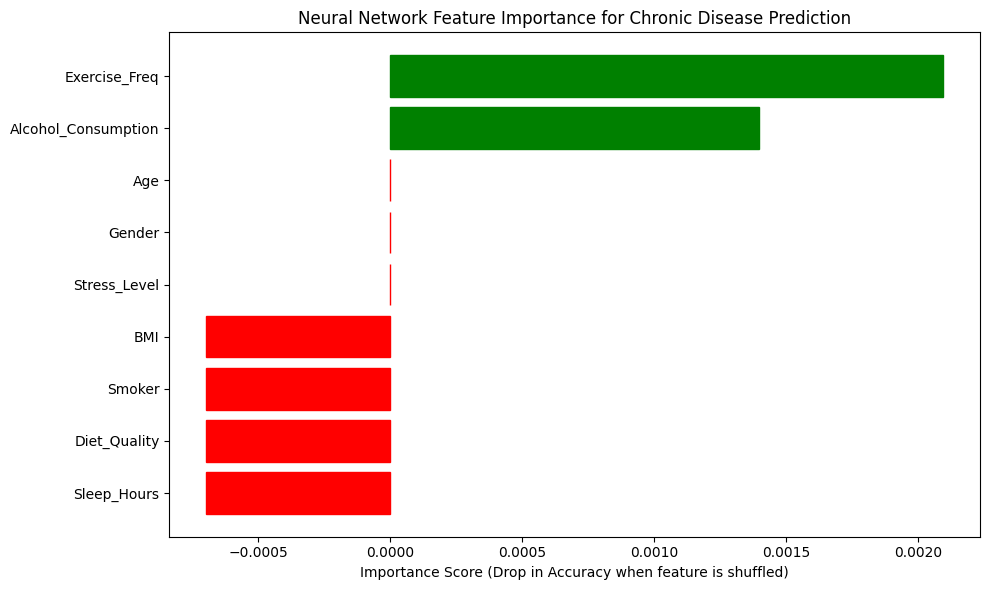


💡 Interpretation:
• Green bars: Features that help predictions (positive importance)
• Red bars: Features that hurt predictions (negative importance)
• Larger bars: More important features
• Zero importance: Feature doesn't matter for this model


In [35]:
# Calculate permutation feature importance for neural network
print("🔍 NEURAL NETWORK FEATURE IMPORTANCE")
print("=" * 45)

def calculate_permutation_importance(model, X_test, y_test, feature_names):
    """Calculate how much each feature contributes to predictions"""
    model.eval()
    
    # Get baseline performance (accuracy)
    with torch.no_grad():
        baseline_prob = model(X_test)
        baseline_pred = (baseline_prob > 0.5).float()
        baseline_accuracy = accuracy_score(y_test.numpy(), baseline_pred.numpy())
    
    importance_scores = {}
    
    for i, feature_name in enumerate(feature_names):
        # Create a copy of test data
        X_permuted = X_test.clone()
        
        # Shuffle this feature (break its relationship with target)
        perm_idx = torch.randperm(X_permuted.shape[0])
        X_permuted[:, i] = X_permuted[perm_idx, i]
        
        # Get performance with shuffled feature
        with torch.no_grad():
            permuted_prob = model(X_permuted)
            permuted_pred = (permuted_prob > 0.5).float()
            permuted_accuracy = accuracy_score(y_test.numpy(), permuted_pred.numpy())
        
        # Importance = how much performance dropped
        importance = baseline_accuracy - permuted_accuracy
        importance_scores[feature_name] = importance
        
        print(f"{feature_name:<20}: {importance:.4f}")
    
    return importance_scores, baseline_accuracy

# Calculate feature importance
feature_names = X_train.columns.tolist()
nn_importance, baseline_performance = calculate_permutation_importance(
    model, X_test_tensor, y_test_tensor, feature_names
)

# Convert to DataFrame and sort
importance_df = pd.DataFrame.from_dict(nn_importance, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

print(f"\n📊 FEATURE IMPORTANCE RANKING:")
print(f"Baseline Accuracy: {baseline_performance:.3f}")
print("\nMost Important Features:")
print(importance_df.head().round(4).to_string())

# Visualize feature importance
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(importance_df)), importance_df['Importance'])
plt.yticks(range(len(importance_df)), importance_df.index)
plt.xlabel('Importance Score (Drop in Accuracy when feature is shuffled)')
plt.title('Neural Network Feature Importance for Chronic Disease Prediction')
plt.gca().invert_yaxis()

# Color bars - positive importance = helpful feature
for i, bar in enumerate(bars):
    if importance_df.iloc[i, 0] > 0:
        bar.set_color('green')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
print(f"• Green bars: Features that help predictions (positive importance)")
print(f"• Red bars: Features that hurt predictions (negative importance)")
print(f"• Larger bars: More important features")
print(f"• Zero importance: Feature doesn't matter for this model")

## 10. Summary and Key Takeaways

**🎉 Congratulations! You've built and trained a neural network from scratch!**

### What We Learned:

**1. Neural Network Basics:**
- Neural networks are collections of connected neurons organized in layers
- They can learn complex, non-linear patterns in data
- Training involves forward passes, loss calculation, and backpropagation

**2. Data Preparation for Neural Networks:**
- Feature scaling is crucial for neural networks
- Label encoding vs one-hot encoding trade-offs
- Converting data to PyTorch tensors

**3. Model Architecture:**
- Input layer → Hidden layers → Output layer
- ReLU activation functions for non-linearity
- Dropout for regularization (preventing overfitting)

**4. Training Process:**
- Loss functions (Binary Cross-Entropy for classification)
- Optimizers (Adam for efficient training)
- Batch processing for computational efficiency
- Monitoring training and test loss

**5. Advanced Techniques:**
- Early stopping to prevent overfitting
- Cross-validation for robust performance estimates
- Architecture experimentation
- Feature importance analysis

### When to Use Neural Networks vs Traditional ML:

**Use Neural Networks when:**
- ✅ Large datasets (thousands+ of samples)
- ✅ Complex, non-linear relationships
- ✅ High-dimensional data
- ✅ Performance is critical

**Use Traditional ML when:**
- ✅ Small datasets (hundreds of samples)
- ✅ Need interpretable results
- ✅ Limited computational resources
- ✅ Linear relationships in data


**Remember**: Neural networks are powerful tools, but they're not always the best solution. Understanding when and how to use them is key to being an effective data scientist!

## 🎯 Exercises for Further Practice

**Beginner Exercises:**
1. Change the number of neurons in hidden layers (try 32, 128, 256)
2. Modify the learning rate (try 0.01, 0.0001)
3. Experiment with different dropout rates (0.1, 0.3, 0.5)
4. Try training for more or fewer epochs
5. Try using different features

**Intermediate Exercises:**
1. Add a third hidden layer to the network
2. Use different activation functions (try `nn.Tanh()` instead of `nn.ReLU()`)
3. Implement learning rate scheduling
4. Try different optimizers (SGD, RMSprop)
5. Use correlation matrix and/or PCA for feature selection


Try these exercises to deepen your understanding of neural networks and deep learning!